# Emotion Detection Project
Authors: Allyson, Anusha, Devyani

## About Our Dataset
We are using the [Emotion Detection](https://www.kaggle.com/ananthu017/emotion-detection-fer) dataset from Kaggle.

We chose this dataset because of the large amount of images available, and how they are already divided into subfolders that represent their class labels. Many other facial recognition datasets had no emotion classification labels or had inconcsistent image data.

In [1]:
#Imports
import os
import PIL
import cv2
import glob
import fastai
import pathlib
import zipfile
import numpy as np
from fastai import *
from PIL import Image
import tensorflow as tf
from fastai.vision import *
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import *
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from fastai.metrics import error_rate, accuracy

In [2]:
#Ignores files in directory made by git
def mylistdir(directory):
    """A specialized version of os.listdir() that ignores files that
    start with a leading period."""
    filelist = os.listdir(directory)
    return [x for x in filelist
            if not (x.startswith('.'))]

In [3]:
#Store path to image dataset
data_path = 'data/'
train_path = data_path + 'train/'
test_path = data_path + 'test/'

## Visualizing the Dataset
The Emotion Detection dataset contains ~35,000 images of 48x48 pixel gray-scale images of faces divided into train and test folders. 
- There are approximately ~28,000 images in our training set and ~7000 images in our test set, each categorized under one of the 7 universal emotion classifications.

In [4]:
#Display class labels
labels= mylistdir(train_path)
labels

['happy', 'sad', 'fearful', 'neutral', 'angry', 'disgusted', 'surprised']

In [5]:
image_count = len(list(pathlib.Path(data_path).glob('*/*/*.png')))
print('Total Image Count:', image_count)

image_count = len(list(pathlib.Path(train_path).glob('*/*.png')))
print('Train Image Count:', image_count)

image_count = len(list(pathlib.Path(test_path).glob('*/*.png')))
print('Test Image Count:', image_count)

28709

Our 7 emotion classifications with corresponding image examples

['happy', 'sad', 'fearful', 'neutral', 'angry', 'disgusted', 'surprised']


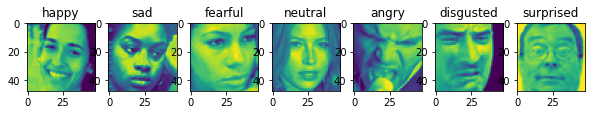

In [7]:
fig, axes = plt.subplots(1, 7, figsize=(10,10))

for i in range(7):

    ex_image = train_path + labels[i]+ '/' + mylistdir(train_path + labels[i]+'/')[0]
    axes[i].imshow(plt.imread(ex_image))
    axes[i].set_title(labels[i])

plt.show()

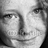

In [8]:
happy = list(pathlib.Path(train_path).glob('happy/*.png'))
PIL.Image.open(str(happy[50]))

## Distribution of Labels

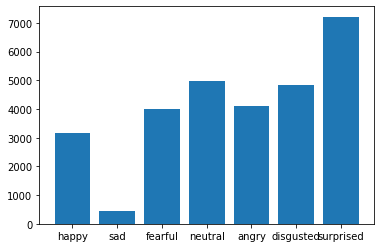

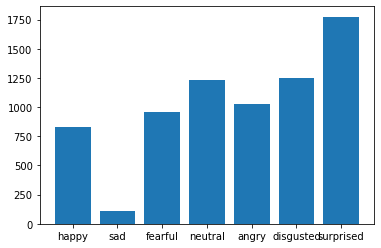

In [36]:
surprised_train = sum(len(files) for _, _, files in os.walk(train_path + 'surprised' + '/'))
disgusted_train = sum(len(files) for _, _, files in os.walk(train_path + 'disgusted' + '/'))
angry_train = sum(len(files) for _, _, files in os.walk(train_path + 'angry' + '/'))
neutral_train = sum(len(files) for _, _, files in os.walk(train_path + 'neutral' + '/'))
fearful_train = sum(len(files) for _, _, files in os.walk(train_path + 'fearful' + '/'))
sad_train = sum(len(files) for _, _, files in os.walk(train_path + 'sad' + '/'))
happy_train = sum(len(files) for _, _, files in os.walk(train_path + 'happy' + '/'))

surprised_test = sum(len(files) for _, _, files in os.walk(test_path + 'surprised' + '/'))
disgusted_test = sum(len(files) for _, _, files in os.walk(test_path + 'disgusted' + '/'))
angry_test = sum(len(files) for _, _, files in os.walk(test_path + 'angry' + '/'))
neutral_test = sum(len(files) for _, _, files in os.walk(test_path + 'neutral' + '/'))
fearful_test = sum(len(files) for _, _, files in os.walk(test_path + 'fearful' + '/'))
sad_test = sum(len(files) for _, _, files in os.walk(test_path + 'sad' + '/'))
happy_test = sum(len(files) for _, _, files in os.walk(test_path + 'happy' + '/'))

train_dist = np.array([surprised_train, disgusted_train, angry_train, neutral_train, fearful_train, sad_train, happy_train])
test_dist = np.array([surprised_test, disgusted_test, angry_test, neutral_test, fearful_test, sad_test, happy_test])
x = np.array(labels)

plt.bar(x, train_dist)
plt.show()

plt.bar(x, test_dist)
plt.show()

Looking at this distribution, there is a significantly smaller amount of images under the sad classification.

## Preprocessing with FastAI

In [9]:
batch_size = 16
img_height = 48
img_width = 48

In [10]:
'''
Is not part of current model, is here for playing around with the dataset
'''
x_train = []
y_train = []
for folder in mylistdir(train_path):
    for img in mylistdir(train_path + folder):
        path = train_path+folder+'/'
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        x_train.append(img_array)
        y_train.append(folder)

In [11]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [25]:
import warnings
warnings.filterwarnings('ignore')

'''
Referenced from FastAI's documentation: https://fastai1.fast.ai/vision.data.html#ImageDataBunch
'''

data = ImageDataBunch.from_folder(data_path, train='train', valid='test', size=48, bs=16)

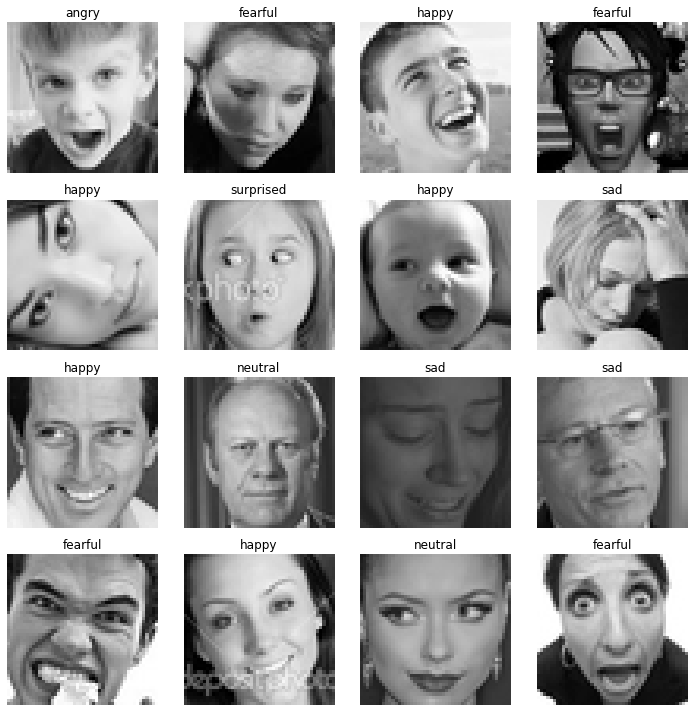

In [26]:
data.show_batch(figsize=(10,10))

In [28]:
data

ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
happy,happy,happy,happy,happy
Path: data;

Valid: LabelList (7178 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
happy,happy,happy,happy,happy
Path: data;

Test: None

In [29]:
data.classes

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [34]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
happy,happy,happy,happy,happy
Path: data;

Valid: LabelList (7178 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
happy,happy,happy,happy,happy
Path: data;

Test: None

## Create CNN Model Learner
Motivation for using CNN: 
- We used CNN (Convolutional Neural Network) for our image classification because of its high accuracy, hierarchical model, and ability to automatically detect important features. It is also computationally effective because all of the layers are fully connected.

In [30]:
learn=cnn_learner(data, models.resnet34, metrics=error_rate)

In [31]:
learn.freeze()

In [33]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.861037,1.785887,0.695598,12:55
1,1.604130,1.549330,0.608387,13:33
2,1.469219,1.431628,0.549178,13:55
3,1.427140,1.383403,0.530649,14:05
4,1.415264,1.362700,0.521872,13:37


In [47]:
#Save and look at weights
learn.save('first_stage')
learn.load('first_stage')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcba587ff70>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Learner(data=ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
happy,happy,happy,happy,happy
Path: data;

Valid: LabelList (7178 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
happy,happy,happy,happy,happy
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu):

In [49]:
#learn.recorder.plot()

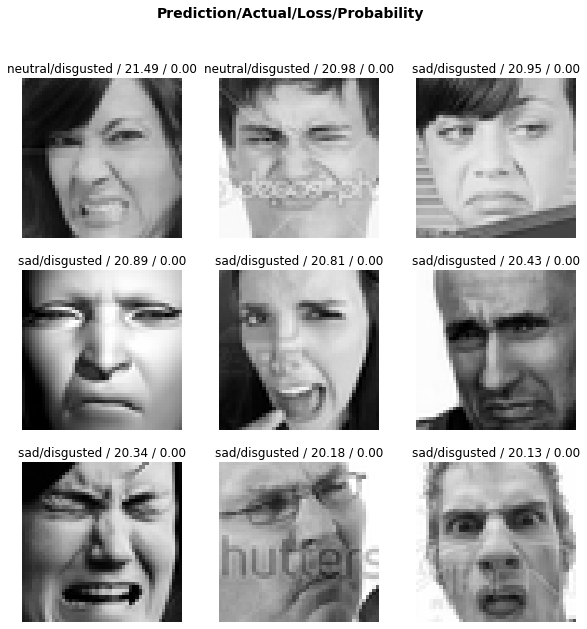

In [39]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9,figsize=(10,10))

In [41]:
interp.most_confused(min_val=2)

[('happy', 'sad', 1621),
 ('neutral', 'sad', 1120),
 ('fearful', 'sad', 896),
 ('angry', 'sad', 867),
 ('surprised', 'sad', 666),
 ('surprised', 'neutral', 165),
 ('happy', 'neutral', 153),
 ('fearful', 'neutral', 128),
 ('disgusted', 'sad', 101),
 ('sad', 'neutral', 99),
 ('angry', 'neutral', 91),
 ('disgusted', 'neutral', 10)]

## Literature Review
[Facial Emotion Recognition Using Convolutional Neural Networks](https://link.springer.com/article/10.1007/s42452-020-2234-1) by Ninad Mehendale
CNN's have become the most popular way to analyze and create predictions for image classifications. This paper explores this idea, as well as the notion that background removal as an initial layer step creates more accurate outcomes for emotion detection in facial recognition projects.

As of right now, there is a lot of fine tuning that needs to be done, and exploring training on other models as well for better outcomes.